**CS-E4890 Deep Learning 2019 - Project Report**

# *Conditional Generative Model for Art Generation* 


# Abstract

The problem of generating new pictures or paintings using deep neural network has been a hot topic and an intriguing challenge for a decade now. In recent years, the implementations have been evolved in a state that neural networks is able to create so believable new images that human cannot recognize if the images are taken with a camera, made by a human or created by neural networks.

We wanted to make this implementation, but with a little twist. In our solution, we give 50 thousand images with 4 different labels (flower pictures, portrait paintings, landscape paintins and abstract paintings) to the neural networks. The network then creates new images by using these 4 paintings, but does not mix the labels. For example, if we want to create new flower images, the neural network creates only new flower images and does not mix them with portraits or other labeled images.

To create new images out of training images, we used Conditional Deep Convolutional Generative Adversial Networks (cDCGAN) and Auxiliary Classifier Deep Convolutional Generative Adversarial Network (ACDCGAN). We used two different conditionality methods to test which one gives more promising results.



# 1. Introduction

The idea of this project was to generate new images using generative adversial networks (GAN). In addition, to just generating random images that resemble the training images, we wanted to specify which type of images should be generated. These type of models are called conditional generative models. Two different model architectures were chosen for this task: Conditional Deep Convolutional Generative Adversarial Network (cDCGAN) and Auxiliary Classifier Deep Convolutional Generative Adversarial Network (ACDCGAN). The model architectures are explained in bit more detail in part 3.

The goal of this project was to generate images of paintings from different genres (e.g. portraits and landscapes). As regular GANs do not scale well to large resolution images, we chose to generate 64x64 sized RGB images (it is also a lot faster to train on smaller images, as there are less parameters...). The data we used for this project was downloaded from (http://academictorrents.com/details/1d154cde2fab9ec8039becd03d9bb877614d351b) and these paintings are originally from wikiart website (https://www.wikiart.org/). This dataset was used for similar project called GANGogh [1].

In this project we started by creating a fairly simple GAN to create images without condition from MNIST dataset, after that we continued to create conditioned images of MNIST. When we succeed on both of these, we changed to datasets which had more variance in the images and RGB colors (i.e. the art dataset and also for practice  the CIFAR10 dataset [2]). We first generated images from a single class and then continued on using more classes as the model started to work.

The methods used on this project are mainly based on examples and implementations that can be found from the Internet and from scientific publications. The basic architecture for DCGAN is from detailed Pytorch example [3], we have then tuned and changed the model to our needs and added the conditioning.

For training the models we used mainly **Nvidia Gtx 1070, Pascal architechture** and also when possible Google Colab. Training time for the models varied from 30 minutes (MNIST) to 10 hours, depending on the number of model parameters and how stable the training was. 

The evaluation of GANs is quite difficult task as good evaluation metrics are lacking, especially for custom data set such as ours. We evaluate the GAN performance mainly manually by monitoring the generated images during the training process and then evaluate the final generated figures by bit more sophisticated methods to see how the GAN performs overall. The evaluation part is explained in more detail in part 4. 

The results of this projects are quite convincing, as we were able to generate quite good-looking images of paintings, our generator did not overfit to the data and the latent space of the generator seems to be well defined (i.e. no areas where the images turn to noise). The main problem was the unstability of the training and so-called mode collapse. This made it hard to train the model simultaneously with many labels and with images with large variation inside single class (e.g. abstract paintings).


# 2. Data analysis/Data description

For this project we used mainly 3 datasets: MNIST, CIFAR10 and the custom art dataset. 

MNIST dataset consists of 50000 training images and 10000 validation images. These are black and white, 28x28 pixel images of handwritten digits (0-9). We used only the training images to train our model as our task was not classification. The handwritten digits is quite easy dataset as there are very little variance inside each class, i.e. all digits inside a single class are quite similar.

CIFAR10 dataset also consist of 50000 training images and 10000 validation images. These are 32x32 resolution RGB images from 10 different classes. In the training set there are 5000 images from each class, which are: plane, car, bird, cat, deer, dog, frog, horse, ship and truck. These images can vary quite a lot from each other even inside a single class. For example, below are 40 images from cifar10-dataset that have the label dog. The images consists of different races of dogs, positions and backgrounds. This can make it difficult for the GAN to learn what are the main features of a dog. Also, images from other classes have this kind of large variance inside the classes. We didn't really find any convincing results on images generated from CIFAR10-dataset, and it was mainly used for practice as it is easily accessible from Torchvision even on the Google Colab.

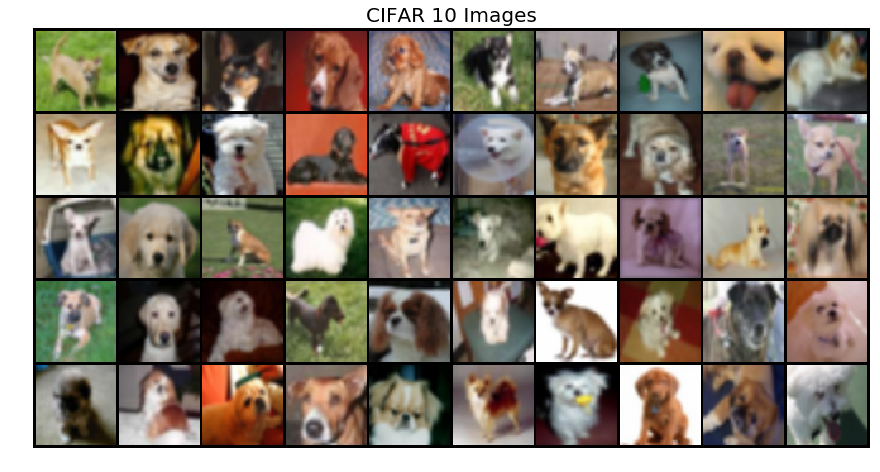

## Art dataset
In the original art dataset there is a total of 14 classes and a varying number of images in each class: abstract (14999), animal-painting (1798), cityscape (6598), figurative (4500), flower-painting (1800), genre-painting(14997), landscape (15000), marina(1800), mythological-painting(2099), nude-painting-nu (3000),portrait (14999), religious-painting (8400), still life (2996) and symbolic-painting (2999). The sizes of the images also vary a lot and most of them does not have equal aspect ratio. For our project we used just *5* of these classes: portraits, landscapes, flower-paintings, cityscape and abstract. We chose these specific classes because they have enough variance from each other, the classes of the images are easily distinguishable, and the images are quite similar inside each class (except abstract). Abstract was added to the classes as basically any image GAN creates could classify to this category.

As the figures have varying aspect ratio and sizes we decided to crop and resize all images to 64x64. For cropping we used center crop as most often the important part of the figure is in the center (vs. random crop). Our dataset consist therefore of total 56800 64x64 RGB images. We had to remove couple of images randomly so that our total number of pictures is divisible by 100 (our batch size). The images are also normalized between -1 and 1.

We actually modified this dataset a bit and changed the flower-paintings to pictures of real flowers. We did this because there were quite few pictures of flower-paintings and the real images of flowers were easier to generate for the GAN. This is probably because the pictures of real flowers had only little variance inside the class (all images are quite similar). Flower dataset is available here: http://www.robots.ox.ac.uk/~vgg/data/flowers/102/.

There was also some corrupted images in the training set so we preprocessed the images and removed corrupted images separately and saved them, before loading them into dataloader. In the end we had 9572 landscapes, 13 677 portraits, 13 384 abstract images, 6598 cityscapes and 8189 flower images in our training data.

<img src="Art_training_data1.png" title= "Training data" >





# 3. Methods and experiments

## Model archtecture
The basic architecture for cGAN and ACGAN is presented in figures 1 and 2 below:

<img src="cGAN1.png" title= "cGAN architecture" >

In regular GAN we just want to generate images that are similar to the training images, i.e. come from the same distribution as them, to fool the discriminator. The cGAN is an extension of regular GAN where we add conditions as extra information (e.g. labels) to the inputs. This conditioning can be done by feeding the conditions into discriminator and generator [4].  
One way this can be though is asking the generator: "Out of this list of different type of images create me one of this *class*.", and respectively, asking the discriminator: "This image is supposed to be of this *class*, is it *real* or *fake*?".

In our cDCGAN model the discriminator has 5 convolutional layers with 4x4 kernel and stride of 2. Strided convolution is preferred over max pooling for down sampling and most implementations that can be found online, follow this rule. After each layer there is batch normalization and as activation function leaky relu with slope 0.2 is used. Batch normalization is supposed to help the optimization process of the GAN and leaky relus should help with sparse gradients. After the last layer a sigmoid function is used to calculate the probability of each sample being true or fake. The image and its label/condition are combined after first convolutional layer. Labels are passed to the discriminator as a one-hot encoded tensor of dimension: batch size x number of labels x image height x image width, where the one-hot encoding is used on the channels (channels correspond to labels). This means that the label is basically an image that has always one channel full of ones and rest full of zeros. This "label image" is put through a single convolutional layer and a leaky relu and then concatenated with the input image that has gone through the same. 

The generator of cDCGAN consists of 5 transposed convolutional layers. Each layer has 4x4 kernel, stride of 2 and after each layer except last there is batch normalization layer. We used LeakyRelu with slope of 0.2 after first 4 convolutional layers and Tanh as output activation. Number of channels after each layer is divided by 2 and start from 512 (i.e. 512->256->...). The labels/conditions are feeded to the generator similarly as in the discriminator.

<img src="CDCGAN_both.png" title= "CDCGAN Generator and Discriminator" >

The Auxiliary Classification GAN is similar to the cGAN, but with the difference of feeding the conditions only to the generator. The discriminator then has additional task of classifying the given images to their classes and also if images are true or fake. Giving the discriminator this additional task is known to improve the performance of the original task and is said to help stabilizing the training [5]. 

<img src="ACGAN1.png" title= "ACGAN architecture" >

The discriminator in the ACGAN has similar layers as the cGAN, but it has 5x5 kernel, stride 2 and padding 2. Also, after 5 convolutional layers the output is passed onto two distinct fully connected layers, where other calculates the probability for if the image is true or fake and other calculates the class probabilities. True fake layer is followed by a sigmoid function and class probabilities by a logarithmic softmax. Convolutional layers are followed by batch normalization and leaky relus with slope 0.2. Batch normalization is not used on the first layer so that the model can learn the mean and the scale of the data distribution [6].

In ACGAN, the labels are fed into the generator. Here we passed the one-hot encoded labels through a fully connected layer which is the followed by 5 transposed convolutional layers, with kernel 4x4 and stride 2. Transposed convolutional layers are followed by batch normalization and leaky relus, except for the last layer which is followed by only a hyperbolic tangent.

<img src="AUXCDCGAN_both.png" title= "CDCGAN Generator and Discriminator" >

For both ACGAN and cGAN the weights of the convolutional layers are initialized from normal distribution with 0 mean and 0.02 standard deviation. For both models we used Adam optimizer with learning rate of 0.0001 - 0.0005, and betas (coefficients used for computing running averages of gradient and its square) were (0.5, 0.999).

Loss for the true/fake predictions is binary cross entropy and for the ACGANs class predictions we used negative log likelihood loss. Losses are calculated for a full batch of fake images and a full batch of true images and then summed. For ACGAN also the class probabilities are calculated and added to the BCE loss.



## Experiments

As mentioned before, we experimented first with MNIST and CIFAR dataset as well as just single class images. Most common problem training GANs is the mode collapse, i.e. the model starts to generate data from a single mode. The data distribution that generator tries to estimate is often multimodal so this is not wanted behavior. In our case this meant that the generator started to generate just one type of images per class, as shown in figure 3 for CIFAR10 dataset.

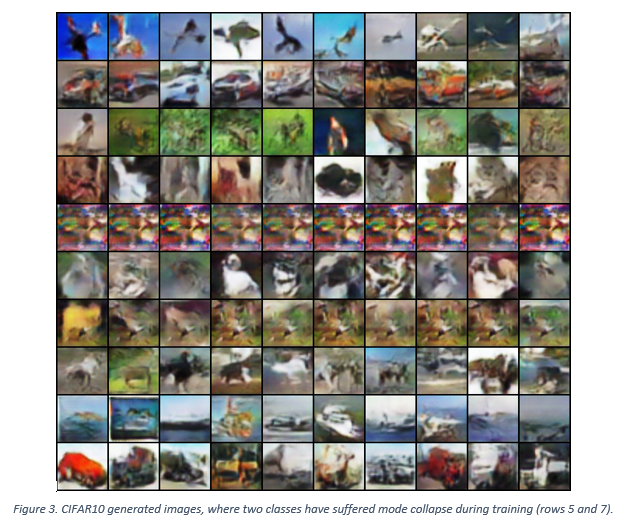

This was quite common sight for us during training of GANs. We tested quite many tricks for stabilizing the training for our model such as: schedulers, smoothing the labels, swapping labels, testing different learning rates, batch sizes, number of channels for our model, adding dropouts after some convolutional layers and testing out experience replay. 

We tried out pretty much just basic scheduler that lowers the learning rate of the optimizer by some given gamma (e.g. 0.5, 0.1...) after given number of steps/epochs. We tested out different strategies, but they did not really give us the expected results. Basically, when we drastically drop the learning rate at e.g. epoch 50, the images start to vary much less. However, it was hard to find the right moment when to do this lowering of the learning rate. We used for the ACGAN step schedulers for both discriminator and generator with step size 50 and gamma 0.75, i.e. the learning rate dropped by 25% at steps of 50 epochs. This worked well when we trained with just small number of labels e.g. 3.

Label smoothing is suggested also to help stabilizing the training as well as helping the neural network, in our case the discriminator, avoid overfitting on the training data [7]. In one sided label smoothing we basically replace the labels of 0 meaning fake and 1 meaning real with a smooth number between, for example 0...0,1 and 0,9...1. We found out that having these smoothed labels and not hard labels helped the GAN training process as the training losses did not go to 0 so easily. We drew the labels from a uniform distribution replacing discriminators zeros by 0...0,2 and its ones by 0,8...1 as this seemed to give most stable results.

Another experiment we did on stabilizing/improving the training was using experience replay. When using experience replay, after each batch a single (or various) image from the generated images is saved for experience replay. Then after N steps, instead of generating new images for training we use these images generated earlier to train the discriminator. However, we didn't find this helping our model learn, so we removed it from the final versions.

For the art dataset we started the process with just 1 label (flowers), so the model was basically a bit modified DCGAN. Then we tried adding more labels and observed the training process with different combinations. Also it was easier to implement and test different variations of the model and try out different hyperparameters for CIFAR10 dataset as we knew more or less how the GAN behaved using that dataset and what were the best possible results for it (comparing results to more state-of-art/complex GANs). After the modifications seemed to work for CIFAR we used them also for the art dataset. 

In the image below is the results of generating flower images using DCGAN at the beginning of our experiments. The model was able to generate real looking flowers based on 8000 training photos. We made this test, to be sure that our algorithm works for a simple problem and that it can really generate new images that look real. It took about 200 epochs for the flowers to look as good as seen below.


<img src="flower_1.png" title= "flowers after 3 epochs" >

<img src="flower_2.png" title= "flowers after 30 epoch" >

<img src="flower_3.png" title= "flower after 65 epochs" >


After this we tested that the conditionality in neural network works. MNIST data was used for this, as it has only 10 simple labels (numbers from 0 to 9) and thus it does not take a lot of time to get in a good result. It takes only 1 epoch for our implementation to get in a good result and after less than 20 epochs it has pretty much converged.

<img src="mnist_0.png" title= "Mnist at the beginning" >

<img src="mnist_1.png" title= "Mnist 1 epoch" >

<img src="mnist_3.png" title= "Mnist 2 epochs" >


After these tests we started the real testing/evaluating. Below you can see how our cDCGAN implementation creates new flowers and portraits out of shuffled training set of flowers and portraits. each iteration of the animation corresponds to driving 10 epochs, thus the last generation of pictures you see is the result after 200 epochs (8 hours of training with Nvidia Gtx 1070, Pascal architechture). In this case, the portraits and flowers look quite good and do not mix with each other.

<img src="two_labels.png" title= "Conditional dcgan training with two labels" >



## 4. Results/Evaluation

As stated in the beginning we evaluated our GANs by just staring at the images generated during the training and tried to tune all the parameters so that the training process would be as stable as possible and that the generated images would look good. We also monitored the losses of both discriminator and generator, but they didn't give much insight of what was going on in the training process (see figure below). However, it is a good sign when the losses do not have too much variance and that the losses are dropping during the training (notice that the discriminator has much lower loss -> it is overpowering the generator) .

<img src="GAN_loss.png" title="Training Loss" width="600" height="400">

When there seemed to be no more real variation in the generated images, we stopped the training and evaluated the generated images more. To check if the model had just overfitted to training data we did latent space interpolation. In latent space interpolation we create two noise vectors and generate images from them. Then we do linear interpolation between each dimension of the latent/noise vectors and generate images also from those interpolations. This way we see how one image "transforms" to another. If this is smooth process and there are no voids in the latent space, then the generator has learned well how to map noise into images and has not overfitted. Note that we did this step only for the final versions of the models and for the final data. Example of a latent space interpolation is shown in figure below, there we can see that the transition is quite smooth from one generated image to another and this indicates that the generator has not overfitted.

<img src="Gan_interpolation.png" title= "Latent Space Interpolation" >

Another simple way to evaluate cGAN performance is to see how it can use the conditions to generate images of given label even though the latent vector is the same. Below are results from an ACGAN that has been trained to generate images from 3 labels: landscapes, portraits and flowers. Note that figures in same place in the grid correspond to same latent vector with a different label.

<img src="Condition1.png" title="Landscapes">

<img src="Condition2.png" title="Portraits">

<img src="Condition3.png" title="Flowers">

From these figures we can see that in this case the generator did learn quite well to use the class labels to generate correct images. There are, however, some that seem to be out of place (portrait looking flowers in right bottom) and some of the images are quite messy. Overall, however the image quality is quite good. Also, a nice touch from the generator can be seen in the middle row second last image, where the generator has created a red landscape, person in red dress and a red flower. Clearly there is some areas in the latent space which are connected to the color of the generated images.

To have more insight of the results of the training we can see what discriminator thinks about the images generated by the GAN. Again, for the same ACGAN model lets print top 10 images from each class (i.e. images that have highest probability of being real). Below the figures, are the probabilities of discriminator classifying the image as real. All of the top images are classified correctly by labels(landscapes are landscapes, portraits are portraits...).

<img src="toplandscapes.png" title="Landscapes">

<img src="topportraits.png" title="Portraits">

<img src="topflowers1.png" title="Flowers">

Interestingly, it seems that the generator can generate easily landscapes that fool the discriminator and look quite realistic. In portraits and flowers however, the generator is not able to trick the discriminator and it can distinguish most of the images as fakes. Strangely, generator is able to fool the discriminator with portraits that do not look much like portraits and it seems that fooling the discriminator with flowers requires very realistic images, i.e. it can distinguish fake flowers from real the best. In addition, it seemed that the discriminator gave higher probability to images that didn't even look like flowers than the ones that for us seemed quite realistic. For example, below are 4 quite good-looking flowers, that discriminator has classified as obvious fakes:

<img src="notsogood.png" title="Flowers">

Sadly, we didn't get the ACGAN working for more than 3 labels at the time (or at least the images did not look good enough to add to the report) and most of the time the training process failed quite quickly. It is also likely that the problem was not in our model, but in the images of some specific label, or that some labels such as abstract were too demanding for our ACGAN to generate.

Results presented above are not that far from a more complex "state-of-art" version of the art generator GANGogh [1].

Below is presented the development of CDCGAN with 4 different labels. Labels are Portraits, Abstracts, Landscapes and Flowers.

<img src="CDCGAN_1.png" title="Flowers">

After first epoch the generator has not yet figured out any features out of the pictures. The training is of course in the beginning and thus the result are not good yet. The next image presents the pictures after 35 epochs

<img src="CDCGAN_31.png" title="Flowers">

After 35 epochs the images are starting to look similar as the training images. However, training still needs to be continuing as the results are getting better and algorithm has not converged to any local minimum yet. The next image presents the pictures after 95 epochs

<img src="CDCGAN_91.png" title="Flowers">

After 95 epochs the images look really similar as their training images. After this the training could not continue as the generator started to create white noise and development stopped.







## 5. Discussion/Conclusions

Most of the struggles on the project was trying to find the balance how to train the GAN and trying to make it converge using the same model but varying its hyperparameters. Big problem was also that when training the GAN it could easily take hours to get to see the first meaningful results and up to 8 hours to see if the changes made had truly improved the training.

However, as a conclusion we succeeded quite well on generating images from few classes (with cDCGAN 4 classes with Ok results) at a time from the art dataset. We didn't succeed at generating and training the GAN with all possible data and labels available at once, as the images were most likely too demanding for our models. This could probably be done by creating more advanced and/or stable models such as Wasserstein GAN which is a modification of GAN that uses completely different cost function called Earth-Movers distance and a bit more complex training scenario [7]. There are also ton of other GAN variants that could be tested for generating this type of images such as Stacked GAN or Dropout GAN to name a few. However, from the point of view of this project this was out of scope due to time and resource limitations. To be noted also was that the number of labels was not really a problem as the models did easily learn MNIST and CIFAR10(with CIFAR10 the images were not that impressive) datasets, but the variance inside the classes seemed to be bit too much for our model.

Looking from a bright side our models didn't overfit on the training data and were able to create average looking images from few classes at a time. We were also able to prove this by exploring the latent space and investigating the behaviour of our models discriminator and generator.

When compared our generated images to for example images generated by state-of-art GANgogh[1] our images are clearly worse (example landscape images generated by **GANGogh not our model** are below). However, the images generated by our model are not that bad and some of them could pass as art. Also generating conditioned images already is quite demanding task and our models are able to do it quite well, even if it is just few classes at a time.

<img src="Gangogh_landscape.png" title="GANGogh Landscapes">

Another approach when dealing with dataset with many images and different classes is to train many GANs for a smaller subset of the original dataset. For example, if we have 100 different classes in the dataset splitting the images into subsets where in each subset there is just images from 10 classes and then training a single GAN on each subset can have very good results as shown in [5], where ImageNet-dataset was used.


## 6. References

[1] https://towardsdatascience.com/gangogh-creating-art-with-gans-8d087d8f74a1  (Accessed 11.5.2019)

[2] https://www.cs.toronto.edu/~kriz/cifar.html (Accessed 11.5.2019)

[3] https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html (Accessed 13.5.2019)

[4] Mirza, M., Osindero, S. *Conditional Generative Adversial Nets*, CoRR, abs/1411.1784, 2014.  Available: http://arxiv.org/abs/1411.1784.

[5] Odena, A. & Olah, C. & Shlens, J. *Conditional Image Synthesis With Auxiliary Classifier GANs*. 2016. Available: https://arxiv.org/pdf/1610.09585.pdf

[6] I. J. Goodfellow, *NIPS 2016 tutorial: Generative adversarial networks*. Proc. 34th Int. Conf. Mach. Learn. (ICML), pp. 2642-2651, Aug. 2017. Available: https://www.arxiv.org/abs/1701.00160.

[7]  Arjovsky, M. & Chintala, S. & Bottou, L. *Wasserstein generative adversarial networks*, Proc. 34th Int. Conf. Mach. Learn. (ICML), pp. 214-223, Aug. 2017.


## Appendix Source code

https://github.com/mvhel/GANasso

You can find your source code from the above github repository.


ACDCGAN.ipynb - Our implementation of the Auxiliary Conditional Deep Convolutional Generative Adversarial Network source code. 

CDCGAN.ipynb - Our implementation of the Conditional Deep Convolutional Generative Adversarial Network. 

We used both of these notebooks to get two different kind of results.

(https://mycourses.aalto.fi/pluginfile.php/929341/mod_resource/content/3/project_work_evaluation_form.txt)

# Vielä puuttuu:
- 1 Cifar kuva experimentteihin
- CDCGAN tulokset
- Github repo private --> Public
- Hyvissä ajoin kokeilla että rapsa pysyy kasassa kun siirtää ipynb --> PDF
- Voiko/onko helppo lisätä giffejä lisätä github repoon?

